In [205]:
from scipy.io import wavfile
import numpy as np
import scipy.signal as sp
import scipy as scipy
import matplotlib.pyplot as plt
import pandas as pd
import soundfile as sf
import museval

In [206]:
x1, fs1 = sf.read('x1.wav')
x2, fs2 = sf.read('x2.wav')
x3, fs3 = sf.read('x3.wav')
s1, fs_s1 = sf.read('s1.wav')
s2, fs_s2 = sf.read('s2.wav')
s3, fs_s3 = sf.read('s3.wav')

In [207]:
# 標準化
M = len(x1)#信号のサンプル数
x = np.zeros((3, len(x1)))
x[0,:] = (x1 - np.mean(x1))/np.sqrt(np.nanvar(x1))
x[1,:] = (x2 - np.mean(x2))/np.sqrt(np.nanvar(x2))
x[2,:] = (x3 - np.mean(x3))/np.sqrt(np.nanvar(x3))
print(x.shape)

# 観測信号の白色化化
R = np.dot(x, x.T)/M
eig_v, Q = np.linalg.eig(R)
Lambda = np.diag(eig_v)
V = np.dot(np.sqrt(np.linalg.inv(Lambda)), Q.T)
xh = np.dot(V,x)

b_past = np.array(([1,1,1],[0,0,0],[0,0,0]),dtype=float)
b = np.array(([1,1,1],[0,0,0],[0,0,0]),dtype=float)
print(b.shape)

def ICA(m_component, max_iter):
    for m in range(m_component):
        for i in range(max_iter):
            b_past[:,m] = b[:,m]
            sh = np.dot(b[:,m].T, xh)
            # fourth moment - kurtosis
            b[:,m] = np.mean(xh * np.power(sh,3).reshape(1, -1), axis=1) - 3*b[:,m]

            # Gram-Schmidt process
            if m > 0:
                for j in range(m):
                    b[:,m] -= np.dot(np.dot(b[:,m].T, b[:,j]), b[:,j])
            
            # Normalize
            b[:,m] /= np.linalg.norm(b[:,m])
            
            if np.abs(np.abs(np.dot(b[:,m].T, b_past[:,m])) - 1) < 10**-6:
                break
        # print("iteration = ",i)
    return np.dot(b.T, xh)  

sh = ICA(3,100)
s = np.vstack((s1,s2,s3))
print(sh.shape,xh.shape)

(3, 441000)
(3, 3)
(3, 441000) (3, 441000)


In [208]:
def z_score(x):
    new_val = []
    for i in range(3):
        new_val = np.append(new_val, (x[i,:] - np.mean(x[i,:]))/np.std(x[i,:]))
    new_val = new_val.reshape(sh.shape[0],sh.shape[1])
    return new_val
s_normalized = z_score(s)
#Sh already have mean = 0, and std = 1

Text(0.5, 0.98, 'The Source signals and The recovered signals after z-score Normalized ')

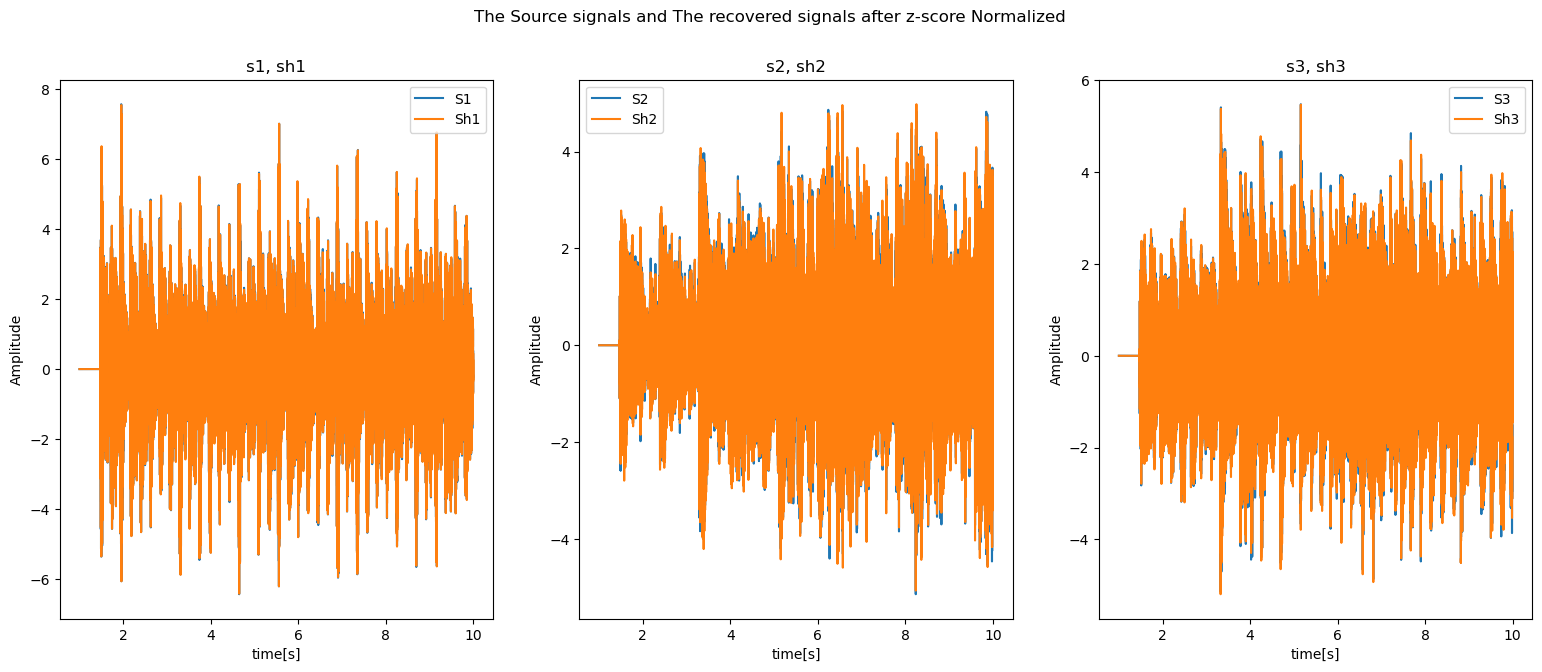

In [209]:
t = np.linspace(1,10,fs_s1*10)
s_title = ["s1, sh1","s2, sh2","s3, sh3"]
# sh_title = ["sh1","sh2","sh3"]
fig, axs = plt.subplots(1,3,figsize=(19, 7),sharex= True)
for i in range(3):
        axs[i].plot(t, s_normalized[i,:], label='S{}'.format(i+1))
        axs[i].plot(t, sh[i,:], label='Sh{}'.format(i+1))
        axs[i].set_title(s_title[i])
for ax in axs.flat:
    ax.set(xlabel='time[s]', ylabel='Amplitude')
    ax.legend()
fig.suptitle('The Source signals and The recovered signals after z-score Normalized ')


In [210]:
signal_power = np.var(s_normalized, axis=1)   # Power of original signal 
noise_power = np.var((s_normalized - sh),axis=1)
print(noise_power)
snr = 10*np.log10(signal_power/noise_power)
print("SNR : ",snr)

[0.00087677 0.02028232 0.0167403 ]
SNR :  [30.57112527 16.92882447 17.76236713]


In [211]:
MSE = []
for i in range(3):
    MSE = np.append(MSE,np.sum(np.power((s_normalized[i,:] - sh[i,:]),2))/(sh.shape[1]))
print('MSE :',MSE)

MSE : [0.00087677 0.02028232 0.0167403 ]


In [212]:
SDR,ISR,SIR,SAR = museval.evaluate(s_normalized,sh)
print('SDR :',np.mean(SDR,axis=1))
print('ISR :',np.mean(ISR,axis=1))
print('SIR :',np.mean(SIR,axis=1))
print('SAR :',np.mean(SAR,axis=1))

SDR : [30.79706939 16.73177491 17.944592  ]
ISR : [56.76658415 36.23736372 37.80026844]
SIR : [30.80677995 16.6701663  17.91206499]
SAR : [64.13168999 71.00577828 63.13435588]


(441000, 6)


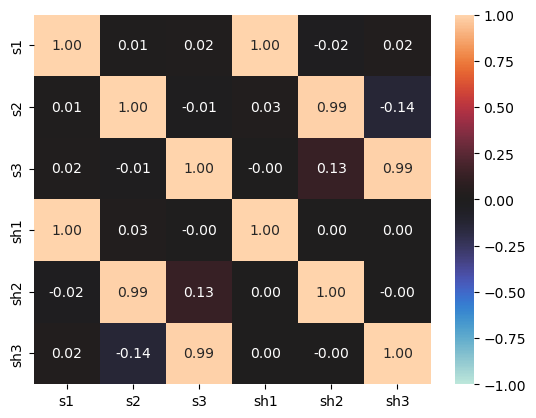

In [213]:
s_sh = np.concatenate((s,sh),axis= 0).T
print(s_sh.shape)
df = pd.DataFrame(s_sh, columns = ['s1','s2','s3','sh1','sh2','sh3'])
corr_mat = df.corr(method='pearson')
import seaborn as sns
sns.heatmap(corr_mat,
            vmin=-1.0,
            vmax=1.0,
            center=0,
            annot=True, # True:格子の中に値を表示
            fmt='.2f',
            xticklabels=corr_mat.columns.values,
            yticklabels=corr_mat.columns.values
           )
plt.show()


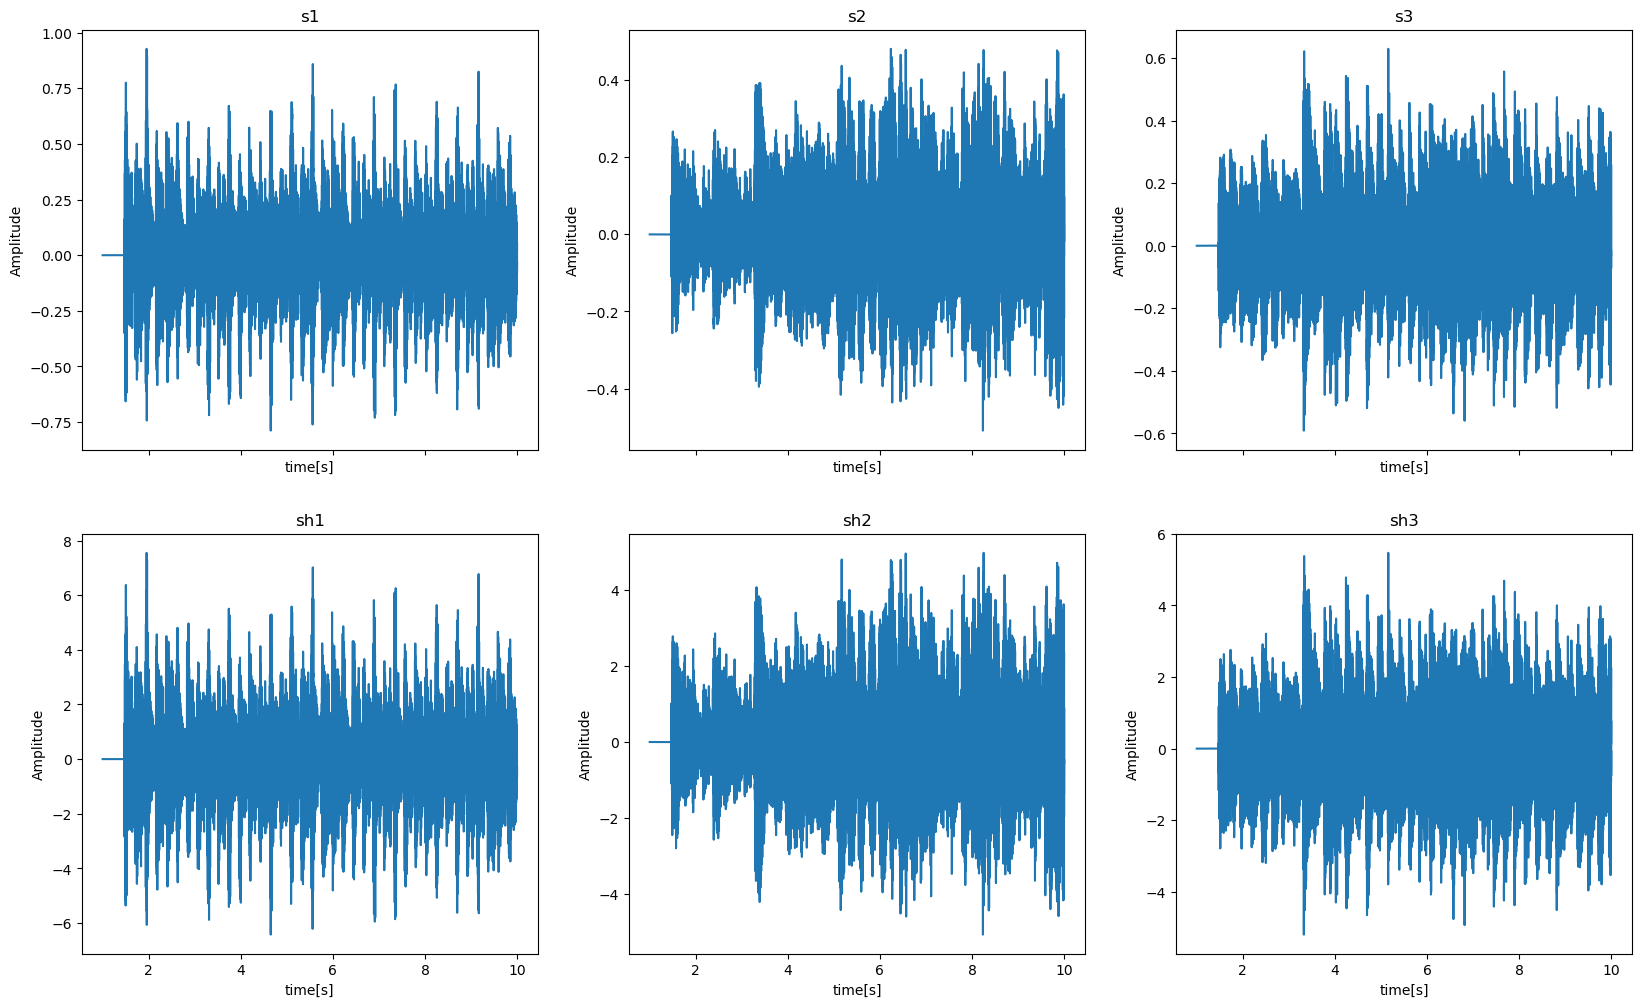

In [214]:
t = np.linspace(1,10,fs_s1*10)
s_title = ["s1","s2","s3"]
sh_title = ["sh1","sh2","sh3"]
fig, axs = plt.subplots(2, 3,figsize=(20, 12),sharex= True)
for i in range(2):
    if (i == 0):
        y = s
        title = s_title
    else:
        y = sh
        title = sh_title
    for j in range(3):
        axs[i, j].plot(t, y[j,:])
        axs[i, j].set_title(title[j])
for ax in axs.flat:
    ax.set(xlabel='time[s]', ylabel='Amplitude')